In [1]:
from github.experiment1.src.process_data import save_maps, load_maps, index2sentence
from github.experiment1.src.dataset import TranslationDataset, AutoencoderDataset, padding_collate_fn, Batch
from github.experiment1.src.encoderdecoder import EncoderDecoder, save_model, load_model
from github.experiment1.src.loss import LabelSmoothing
from github.experiment1.src.optimizer import get_std_opt
from github.experiment1.src.train import train, train_translation_semisupervised, train_translation_semisupervised2
from github.experiment1.src.evaluate import evaluate_translation_two_models, evaluate_translation
import gc

In [18]:
import torch
from torch import nn
import matplotlib
matplotlib.use("module://ipykernel.pylab.backend_inline")
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, 'C:\\Users\\scj14\\BYU\\research\\image_encoder\\github\\experiment1')

In [4]:
src_name = "fra_txt-2021-04-13-13-35"
trg_name = "fra_eng-2021-04-13-15-26"

src_word2index, src_index2word = load_maps(src_name, map_dir="outputs/maps/")
src_vocab = [word for word, index in src_word2index.items()]
trg_word2index, trg_index2word = load_maps(trg_name, map_dir="outputs/maps/")
trg_vocab = [word for word, index in trg_word2index.items()]

In [5]:
src_path = "text_corpora/prepared/fra-eng/train/fra_3k.txt"
trg_path = "text_corpora/prepared/fra-eng/train/eng_3k.txt"
trans_dataset = TranslationDataset(src_path, trg_path)
trans_dataset.init_using_existing_maps(
    src_vocab, 
    src_word2index, 
    src_index2word,  
    trg_vocab, 
    trg_word2index, 
    trg_index2word,  
)

Converting lines to indices...


In [6]:
src_test_path = "text_corpora/prepared/fra-eng/test/fra.txt"
trg_test_path = "text_corpora/prepared/fra-eng/test/eng.txt"
test_dataset = TranslationDataset(src_test_path, trg_test_path)
test_dataset.init_using_existing_maps(
    src_vocab, 
    src_word2index, 
    src_index2word,  
    trg_vocab, 
    trg_word2index, 
    trg_index2word,  
)

Converting lines to indices...


In [7]:
src_model = load_model(src_name, model_dir="outputs/models/")
trg_model = load_model(trg_name, model_dir="outputs/models/")
src_model = src_model.cpu()
trg_model = trg_model.cpu()
src_model = src_model.eval()
trg_model = trg_model.eval()

In [8]:
batch = Batch([trans_dataset[i] for i in range(len(trans_dataset))])

In [9]:
src_h = src_model.encode(batch.src.cpu())

In [10]:
src_h.shape

torch.Size([2970, 256])

In [11]:
trg_h = trg_model.encode(batch.trg.cpu())

In [12]:
trg_h.shape

torch.Size([2970, 256])

In [13]:
src_h = src_h.detach()
trg_h = trg_h.detach()

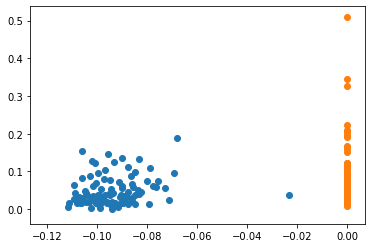

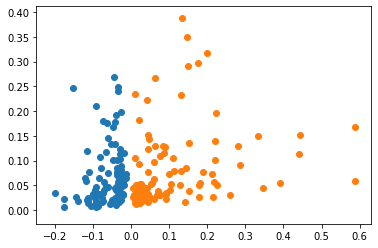

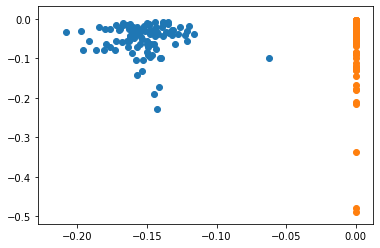

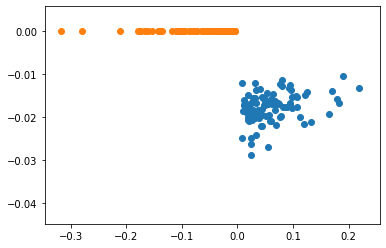

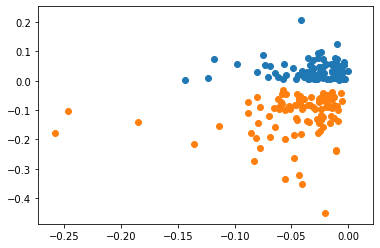

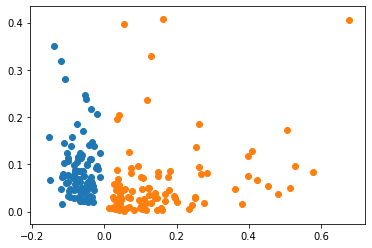

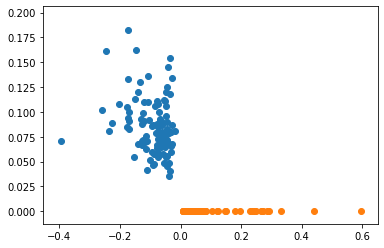

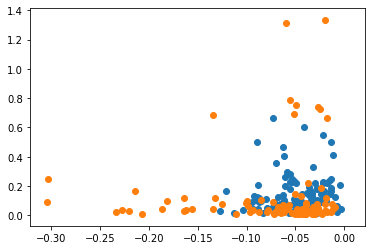

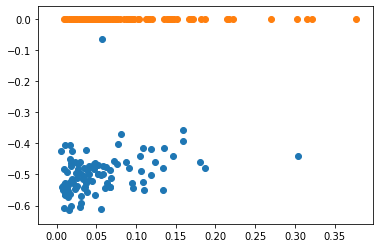

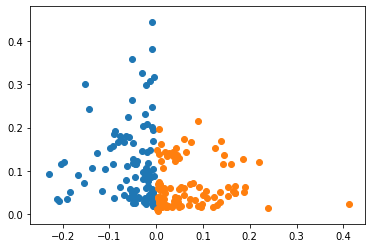

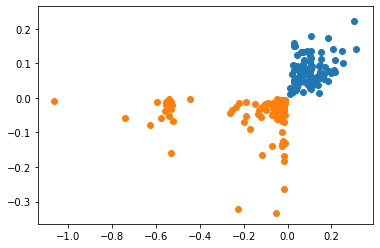

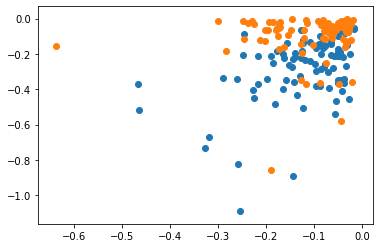

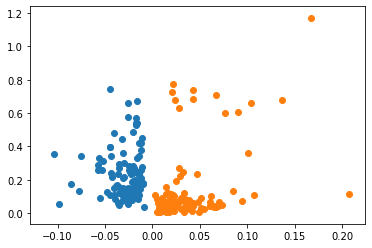

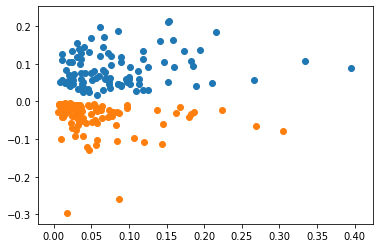

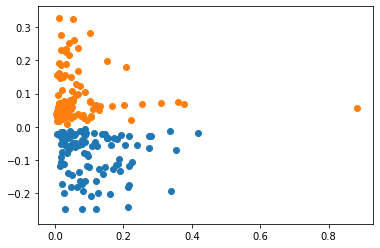

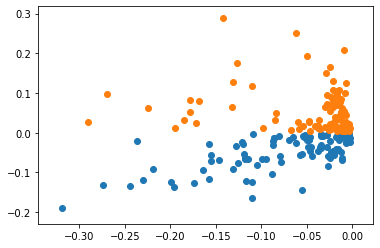

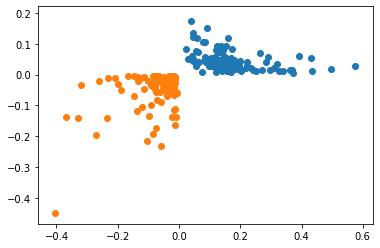

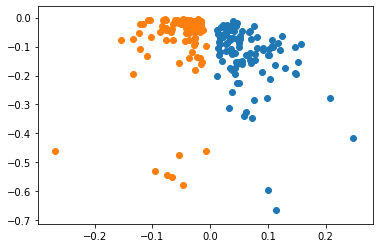

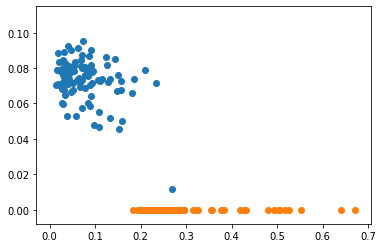

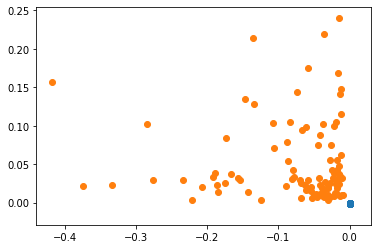

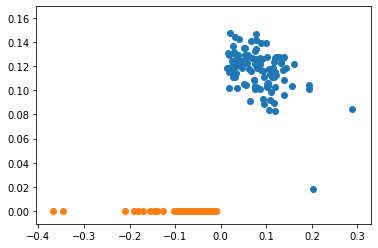

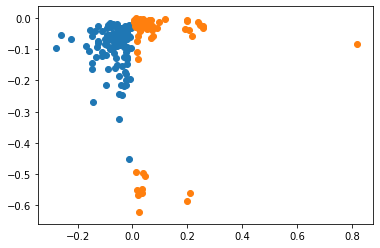

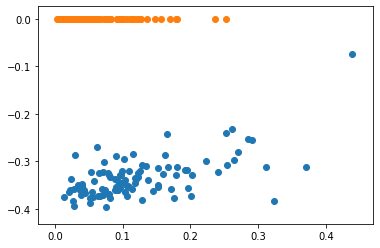

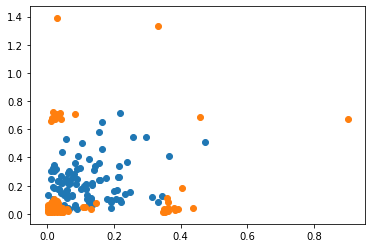

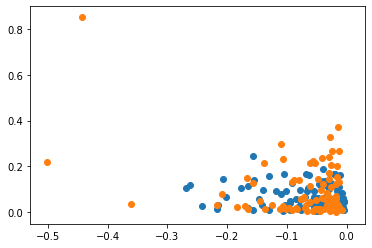

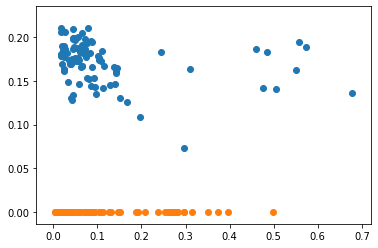

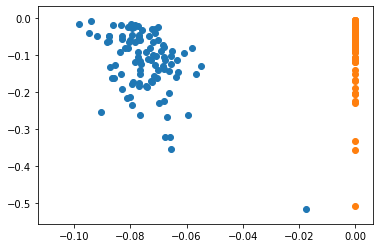

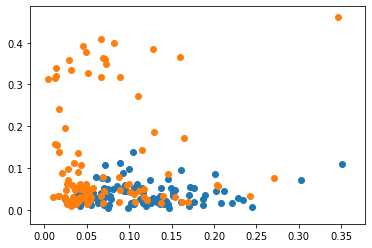

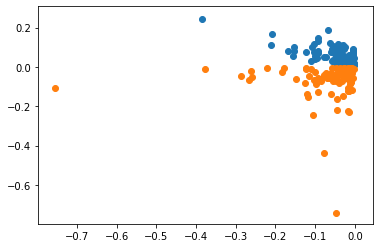

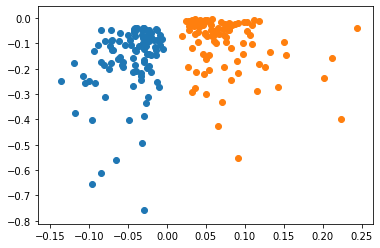

In [19]:
for i in range(30):
    fig = plt.figure()
    plt.scatter(trg_h[:100,0+2*i], trg_h[:100,1+2*i])
    plt.scatter(src_h[:100,0+2*i], src_h[:100,1+2*i])
    plt.show()

In [20]:
model = nn.Sequential(
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256)
)
criterion = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [22]:
cuda = torch.device('cuda')
model.to(cuda)
src_h = src_h.to(cuda)
trg_h = trg_h.to(cuda)

In [45]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10)
for i in range(10000):
    y_hat = model(src_h)
    loss = criterion(y_hat, trg_h)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 1000 == 0:
        print("i: {}, loss: {:.10f}".format(i, loss))

i: 0, loss: 0.0002456237
i: 1000, loss: 0.0002448006
i: 2000, loss: 0.0002440028
i: 3000, loss: 0.0002432271
i: 4000, loss: 0.0002424740
i: 5000, loss: 0.0002417415
i: 6000, loss: 0.0002410254
i: 7000, loss: 0.0002403270
i: 8000, loss: 0.0002396437
i: 9000, loss: 0.0002389761


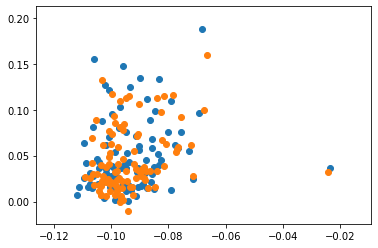

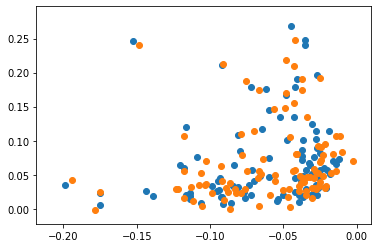

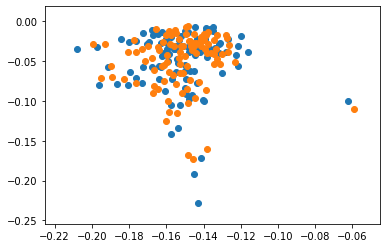

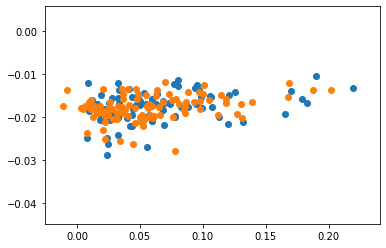

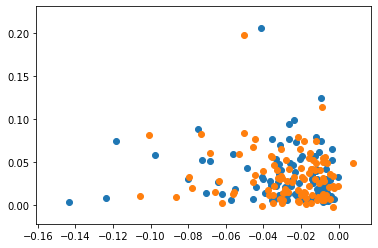

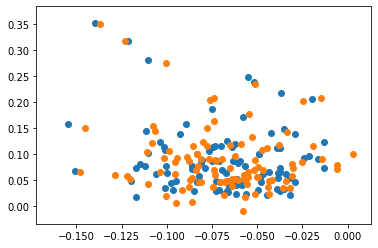

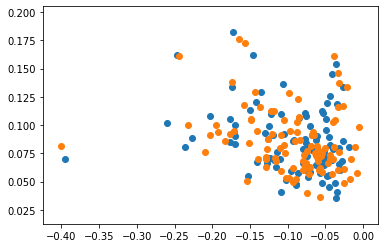

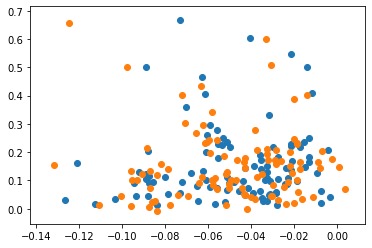

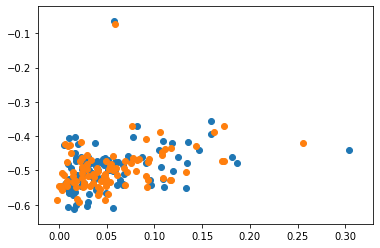

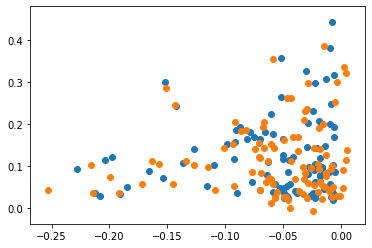

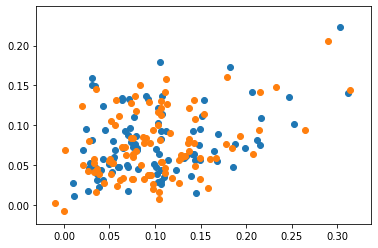

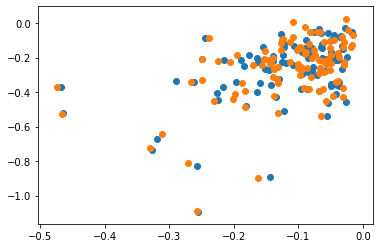

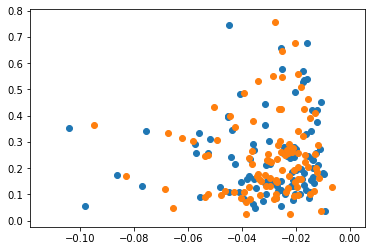

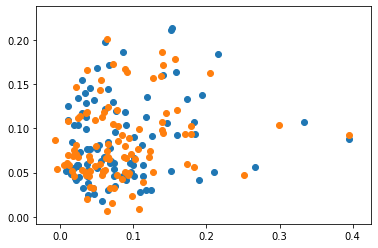

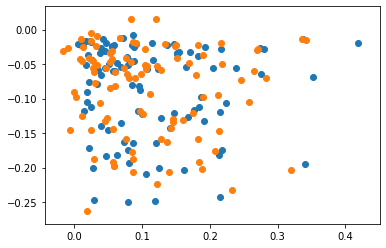

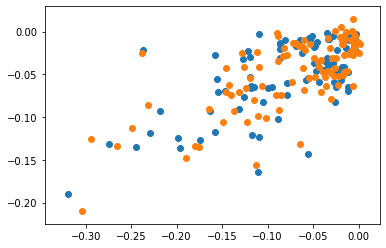

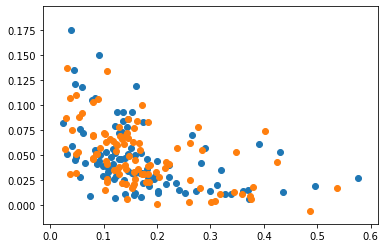

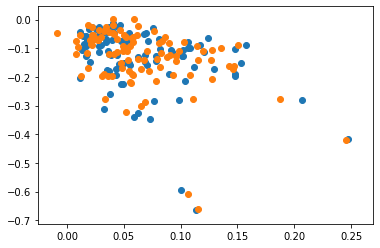

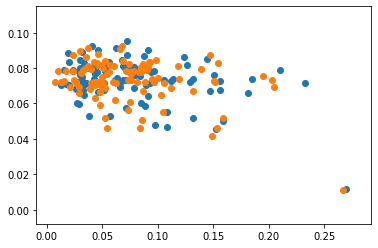

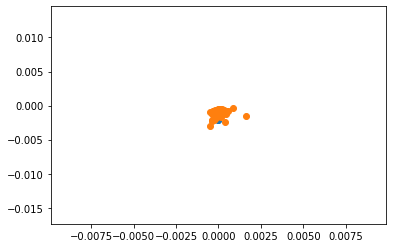

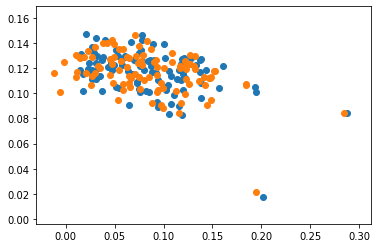

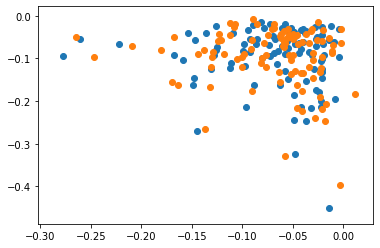

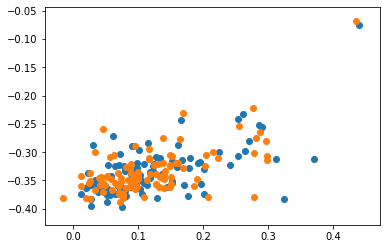

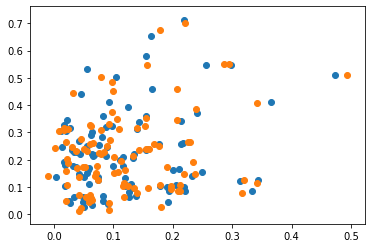

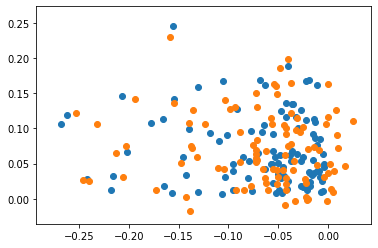

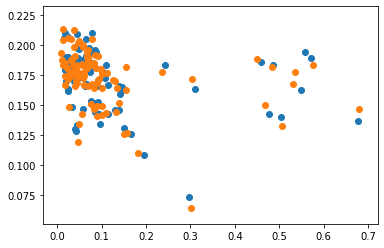

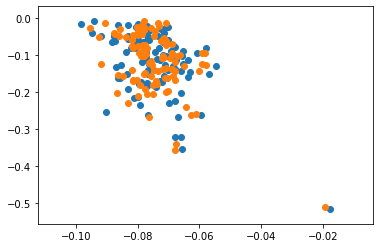

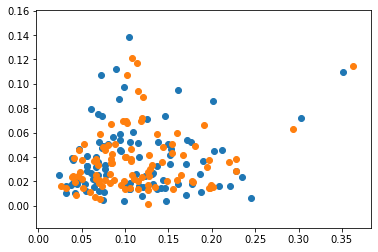

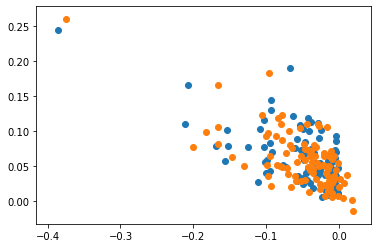

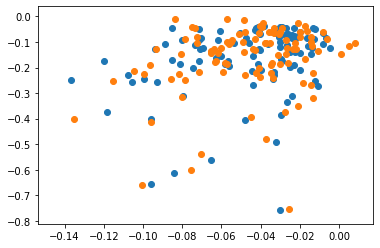

In [46]:
#plt.scatter(x[:,0], x[:,1])
for i in range(30):
    plt.scatter(trg_h[:100,0+2*i].cpu(), trg_h[:100,1+2*i].cpu())
    plt.scatter(y_hat[:100,0+2*i].detach().cpu(), y_hat[:100,1+2*i].detach().cpu())
    plt.show()

In [52]:
trg_model = trg_model.to(cuda)

In [53]:
inp_src = batch.src[0]
for i in range(len(trans_dataset)):
    target = trans_dataset[i][1]
    target = index2sentence(target, trg_index2word)
    memory = trg_model.extract_features(y_hat[i].unsqueeze(0))
    decoded = trg_model.greedy_decode_from_memory(inp_src, memory[0])
    output = index2sentence(decoded[1:].cpu().tolist(), trg_index2word)
    print("Target:", target)
    print("Output:", output)
    print()
    if i > 100: break

Target: are we just friends ?
Output: are we just friends anywhere ? EOS

Target: you should try to write more .
Output: you should try to write more mine . EOS

Target: that s what i wanted .
Output: that s what i wanted today . EOS

Target: you should buy yourself a new knife .
Output: you should buy yourself a new knife . EOS

Target: no one s in sight .
Output: no one s in public around . EOS

Target: you re very rude .
Output: you re very rude . EOS

Target: can you help me with the washing up ?
Output: can you help me with the washing up ? EOS

Target: i m sorry if i scared you .
Output: i m sorry if i scared you . EOS

Target: were you at home all morning ?
Output: were you at home all morning ? EOS

Target: why didn t you just leave ?
Output: why didn t you just leave ? EOS

Target: i ll help you as much as i can .
Output: i ll help you as much as i can . EOS

Target: this is .
Output: this is chance . EOS

Target: i m observant .
Output: i m dedicated . EOS

Target: is it the 

In [57]:
src_model = src_model.to(cuda)

In [58]:
for i in range(len(test_dataset)):
    target = test_dataset[i][1]
    target = index2sentence(target, trg_index2word)
    
    batch = Batch([test_dataset[i]])
    encoded = src_model.encode(batch.src)
    transformed = model(encoded)
    memory = trg_model.extract_features(transformed)
    decoded = trg_model.greedy_decode_from_memory(inp_src, memory[0])
    output = index2sentence(decoded[1:-1].tolist(), trg_index2word)
    print("Target:", target)
    print("Output:", output)
    print()
    if i > 100: break

Target: they live on the floor below .
Output: the cost of living conditions by yourself .

Target: i m surprised to see you .
Output: i m planning to stay quiet .

Target: don t be afraid to make mistakes when speaking english .
Output: we sometimes lack of his place to drive .

Target: let s try it once more .
Output: we have to judge a chance party .

Target: if you had been a little more patient you could have succeeded .
Output: you d better be sure to call a few mistakes you would someone for you .

Target: i m looking forward to christmas .
Output: i immediately catch colds by myself .

Target: i d prefer to speak to you in private .
Output: i d like to see you for next studying .

Target: you were drunk last night weren t you ?
Output: did you reach that meeting today ?

Target: we ll never get through this .
Output: we re very likely we went through .

Target: it s good that i have a daughter .
Output: i know this is a lot of mine .

Target: i didn t know you were awake .
Outp

In [76]:
batch = Batch([test_dataset[0]])

In [78]:
batch.src

tensor([[   1,   78, 2543,   18,   75, 1472,   41, 4092,    8]],
       device='cuda:0')

In [75]:
[test_dataset[i] for i in range(2)]

[([78, 2543, 18, 75, 1472, 41, 4092, 8], [3, 4, 5, 6, 7, 8]),
 ([49, 50, 2586, 54, 23, 33, 8], [9, 10, 11, 12, 13, 14, 8])]